# Terminal commands for data access

```
autossh -AtX vschuma@ssh1.mdc-berlin.de ssh vschuma@murphy.mdc-berlin.net
# open the ssh screen and/or type
ssh -NR 6667:localhost:22 vfs@79.197.179.128 (current network ID)

# mount
sshfs -p 6667 vschuma@localhost:/data/local/rajewsky/home/vschuma /mnt/murphy_workspace/
or
sshfs vschuma@murphy:/data/local/rajewsky/home/vschuma/ ~/mounts/murphy_workspace/

# if working with the mount is to slow, copy the data to a ramdisk
sudo mount -t tmpfs -o size=6g tmpfs /mnt/ramdisk/

# then copy the file to the ramdisk
mkdir /mnt/ramdisk/data && rsync -av /mnt/murphy_workspace/NSTT/data/GarciaAlsono_uterus/hot_data/* /mnt/ramdisk/data
or
mkdir /dev/shm/data && rsync -av /home/vschuma/mounts/murphy_workspace/NSTT/data/GarciaAlsono_uterus/hot_data/* /dev/shm/data/
# symlink inside the pycharm project to the data dir
(example command)
ln -s /mnt/ramdisk/data data
e.g.: ln -s /mnt/murphy_workspace/NSTT/data/ data
or
ln -s /dev/shm/data/ data
```

# Imports

In [1]:
from importlib import reload

import anndata
from bokeh.layouts import column
%matplotlib inline
import importlib.util
import sys
# import novosparc
spec = importlib.util.spec_from_file_location("novosparc",
                                              "/home/vschuma/PycharmProjects/novosparc/novosparc/__init__.py")
novosparc = importlib.util.module_from_spec(spec)
sys.modules["novosparc"] = novosparc
spec.loader.exec_module(novosparc)

import os
import numpy as np
import pandas as pd
import scanpy as sc

# Notebook location

In [2]:
os.getcwd()

'/home/vschuma/PycharmProjects/novosparc/Vic/development'

# Data read in

I use the mouse brain data set used in [this squidpy tutorial](https://squidpy.readthedocs.io/en/stable/auto_tutorials/tutorial_visium_hne.html#sphx-glr-auto-tutorials-tutorial-visium-hne-py).
The preprocessing (atlas creation, dge and cell type extraction was done in the `data_for_celltype_transfer_tesing` notebook.

## atlas and dge
Note that in this case (bc taken from visium data) there are as many (pseudo) cells as locations.

In [3]:
# atlas settings
atlas_dir = 'data'
target_space_path = os.path.join(atlas_dir, '10x_MouseBrain_coordinates.csv')
locations = pd.read_csv(target_space_path, sep=',')
num_locations = locations.shape[0] # coming from the spatial data #
locations_apriori = locations[:num_locations][['xcoord', 'ycoord']].values
locations = locations_apriori

# if the above creates problems when merging with adata try this one:
# locations_apriori = locations[:num_locations][['xcoord', 'ycoord']]
# locations = np.asarray(locations_apriori)
atlas_path = os.path.join(atlas_dir, 'mouse_brain_test_atlas.csv')
# atlas = sc.read_csv(atlas_path, delimiter=',') # this always through a Value Error about unmatching column numbers - idea why

chunks = pd.read_csv(atlas_path, index_col=0, chunksize=1000000)
df = pd.concat(chunks)
atlas = sc.AnnData(df)
atlas_genes = atlas.var.index.tolist()
print(len(atlas_genes))
print(atlas.shape)
print(locations.shape)
atlas.obsm['spatial'] = locations
# Reading expression data to scanpy AnnData (cells x genes)
data_dir = 'data/'
data_path = os.path.join(data_dir, '10x_MouseBrain_dge.csv')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()
num_cells, num_genes = dataset.shape
print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)

<ipython-input-3-126ef26f36f4>:17: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  atlas = sc.AnnData(df)
/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


50
(2688, 50)
(2688, 2)
number of cells: 2688
number of genes: 18078


In [26]:
import matplotlib.pyplot as plt
def embedding_dev(dataset, color, title=None, colorbarlabel = 'probability or UMI count', size_x=None, size_y=None,
              pt_size=10, tit_size=15, dpi=100):
    """
    Plots fields (color) of Scanpy AnnData object on spatial coordinates
    dataset -- Scanpy AnnData with 'spatial' matrix in obsm containing the spatial coordinates of the tissue
    color -- a list of fields - gene names or columns from obs to use for color
    """

    # set plotting frame with number and size of plots
    title = color if title is None else title
    ncolor = len(color)
    per_row = 3 # Fixme: why is this hardcoded anyway? make it dynamic pls
    per_row = ncolor if ncolor < per_row else per_row
    nrows = int(np.ceil(ncolor / per_row))
    size_x = 5 * per_row if size_x is None else size_x # Fixme: this breaks when plotting multiple plots
    size_y = 3 * nrows if size_y is None else size_y # Fixme: see above
    fig, axs = plt.subplots(nrows, per_row, figsize=(size_x, size_y), dpi=dpi)
    xy = dataset.obsm['spatial']
    x = xy[:, 0]
    y = xy[:, 1] if xy.shape[1] > 1 else np.ones_like(x)
    axs = axs.flatten() if type(axs) == np.ndarray else [axs]
    for ax in axs:
        ax.axis('off')

    # plot mapped expression values per gene
    for i, g in enumerate(color):
        if g in dataset.var_names:
            values = dataset[:, g].X
        elif g in dataset.obs.columns:
            values = dataset.obs[g]
        else:
            continue
        im = axs[i].scatter(x, y, c=np.array(values), s=pt_size)
        axs[i].set_title(title[i], size=tit_size)
        fig.colorbar(im, ax=axs[i])
    plt.show()
    plt.tight_layout()
    # fixme: Why doesn't this return anything? You can't do anything with a function like that...cm on....
    print("return another figure object")
    return fig

return another figure object


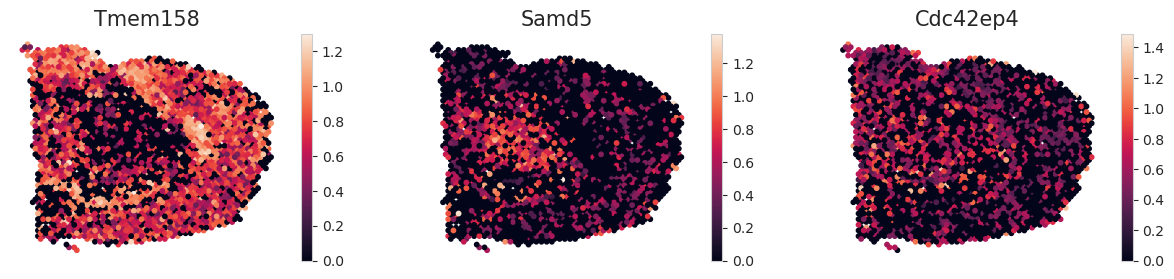

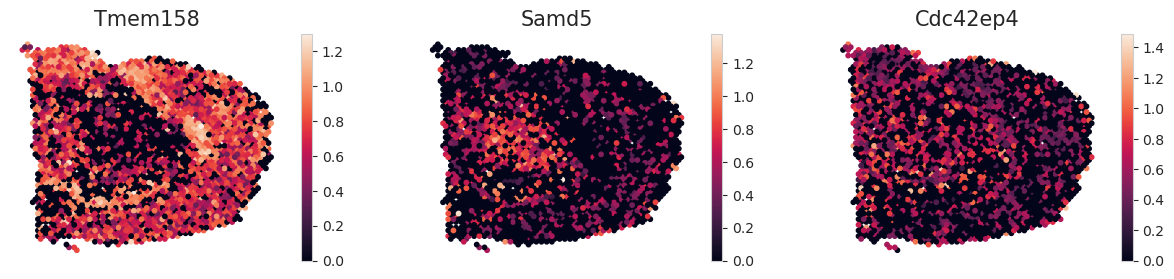

In [27]:
pl_genes = ["Tmem158", 'Samd5', 'Cdc42ep4']
#novosparc.pl.embedding(atlas, pl_genes)
embedding_dev(atlas, pl_genes)

## meta data

In [5]:
meta_data_dir = 'data'
meta_ct_path = os.path.join(meta_data_dir, "mouse_brain_meta_ct.csv")

cell_types_raw = pd.read_csv(meta_ct_path)
cell_type = np.asarray(cell_types_raw)
# cell_type

In [6]:
print(type(cell_types_raw))
print(cell_types_raw.shape)
cell_types_raw[:3]

<class 'pandas.core.frame.DataFrame'>
(2688, 1)


cluster
0    Cortex_2
1    Cortex_5
2  Thalamus_2

# Reconstruction
## create tissue object

In [7]:
# calculate cost matrix
# params for smooth cost # only needed when/for the part where you don't use the atlas!
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)


# setup smooth
num_neighbors_s = num_neighbors_t = 5

# alternative 1: setup both assumptions
tissue.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.1
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

Setting up for reconstruction ... done ( 21.07 seconds )
Reconstructing spatial information with 50 markers: 2688 cells and 2688 locations ... 
Trying with epsilon: 5.00e-03


/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Trying with epsilon: 5.00e-03


In [ ]:
%%time
# writing things to files to use them later
import pickle

#create a pickle file
tissue_file = "tissue_gw.pkl"
picklefile = open(tissue_file, 'wb')
#pickle the dictionary and write it to file
pickle.dump(tissue.gw, picklefile)
#close the file
picklefile.close()

In [ ]:
tissue.gw.shape

# meta data transfer
## prepare gw matrix

In [8]:
gw_matrix = pd.DataFrame(tissue.gw)
type(gw_matrix)
gw_matrix.shape[0]

2688

# use one-hot encoding

## merge celltype with gw

In [9]:
print(cell_types_raw.shape)
print(gw_matrix.shape)
ct_gw_merge = gw_matrix.join(cell_types_raw)
print(ct_gw_merge.shape)
print(ct_gw_merge[:3])

(2688, 1)
(2688, 2688)
(2688, 2689)
              0             1             2             3             4  \
0  3.059879e-04  1.252706e-09  6.642013e-10  1.043016e-09  1.059758e-08   
1  4.135893e-09  3.242720e-04  3.320424e-10  7.571579e-08  5.764577e-09   
2  5.947184e-09  3.996927e-10  3.014582e-04  1.452021e-09  1.642554e-08   

              5             6             7             8             9  ...  \
0  1.249125e-09  6.725484e-08  2.077757e-07  1.102059e-08  1.041035e-08  ...   
1  1.557981e-08  2.034492e-08  2.700747e-08  1.298598e-09  1.051326e-08  ...   
2  2.109268e-08  3.229459e-08  2.797392e-09  1.100197e-09  7.834444e-08  ...   

           2679          2680          2681          2682          2683  \
0  6.659205e-09  1.857860e-08  1.877083e-10  4.335651e-09  7.949094e-09   
1  2.560378e-09  4.203760e-09  1.438191e-09  2.098866e-08  6.703376e-09   
2  2.154366e-07  8.020407e-08  1.650866e-10  6.448941e-10  1.403917e-09   

           2684          2685          26

## encode cell types

In [10]:
# todo: there is maybe a way to get this without transformation to numpy array first
ct_unique = np.unique(cell_type)
print(ct_unique, len(ct_unique))

['Cortex_1' 'Cortex_2' 'Cortex_3' 'Cortex_4' 'Cortex_5' 'Fiber_tract'
 'Hippocampus' 'Hypothalamus_1' 'Hypothalamus_2' 'Lateral_ventricle'
 'Pyramidal_layer' 'Pyramidal_layer_dentate_gyrus' 'Striatum' 'Thalamus_1'
 'Thalamus_2'] 15


In [11]:
help(pd.read_csv)

Help on function read_csv in module pandas.io.parsers.readers:

read_csv(filepath_or_buffer: 'FilePath | ReadCsvBuffer[bytes] | ReadCsvBuffer[str]', sep=<no_default>, delimiter=None, header='infer', names=<no_default>, index_col=None, usecols=None, squeeze=None, prefix=<no_default>, mangle_dupe_cols=True, dtype: 'DtypeArg | None' = None, engine: 'CSVEngine | None' = None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=None, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, cache_dates=True, iterator=False, chunksize=None, compression: 'CompressionOptions' = 'infer', thousands=None, decimal: 'str' = '.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, encoding_errors: 'str | None' = 'strict', dialect=None, error_bad_li

In [12]:
list(cell_types_raw["cluster"].unique())

['Cortex_2',
 'Cortex_5',
 'Thalamus_2',
 'Hypothalamus_2',
 'Cortex_4',
 'Fiber_tract',
 'Lateral_ventricle',
 'Cortex_1',
 'Hypothalamus_1',
 'Striatum',
 'Hippocampus',
 'Pyramidal_layer',
 'Thalamus_1',
 'Cortex_3',
 'Pyramidal_layer_dentate_gyrus']

In [13]:
onehot = pd.get_dummies(cell_types_raw)

## multiply gw and ct

In [14]:
print(gw_matrix.shape) # cells x locations

ct_gw_merge = np.dot(gw_matrix.T, onehot)
print(ct_gw_merge.shape) # locations x ct

(2688, 2688)
(2688, 15)


## adding the matrix  to the tissue object

In [15]:
ctgw_df = pd.DataFrame(ct_gw_merge, columns=ct_unique)
tissue.ctgw = ctgw_df # celltypes are the columns

# check diversity of gw

In [16]:
tissue.gw[0]

array([3.05987939e-04, 1.25270560e-09, 6.64201340e-10, ...,
       1.43476614e-09, 3.51521147e-08, 1.50595280e-08])

## figuring out better way to add metamerge dataframes to the tissue obj

In [17]:
# this is a quick and dirty way, there is a more clean way here: https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string but I'm not so sure about using an additional package for this
tmp1 = ctgw_df
tmp2 = ctgw_df
metadata_mapped = dict()
list_of_df_names = ["tmp1", "tmp2"]
list_of_df = [tmp1,tmp2]
print(metadata_mapped)

for df_name in list_of_df_names:
    for df in list_of_df:
        metadata_mapped[df_name] = df
print(metadata_mapped)

{}
{'tmp1':           Cortex_1      Cortex_2      Cortex_3      Cortex_4      Cortex_5  \
0     8.542351e-06  3.176420e-04  6.361197e-06  7.271159e-06  1.739466e-06   
1     3.514146e-06  1.432501e-06  1.982918e-06  1.712198e-06  3.251670e-04   
2     5.256764e-07  2.445480e-07  3.321325e-07  3.052599e-07  1.095626e-07   
3     4.416404e-06  2.419756e-06  2.561774e-06  2.789043e-06  3.279818e-04   
4     1.448547e-05  8.738800e-06  1.097148e-05  1.104416e-05  3.627632e-06   
...            ...           ...           ...           ...           ...   
2683  7.678128e-06  6.634902e-06  7.889694e-06  3.438388e-06  3.237920e-06   
2684  2.603708e-05  1.802624e-05  1.801565e-05  1.352127e-05  3.596971e-06   
2685  2.413318e-06  2.759947e-06  1.737273e-06  9.846013e-07  4.953106e-07   
2686  1.764663e-05  7.827372e-06  1.038583e-05  1.041602e-05  3.981302e-06   
2687  4.371466e-05  1.760071e-05  2.828347e-05  1.586981e-04  6.279858e-06   

       Fiber_tract   Hippocampus  Hypothalamus_1  H

In [18]:
str(list_of_df)

'[          Cortex_1      Cortex_2      Cortex_3      Cortex_4      Cortex_5  \\\n0     8.542351e-06  3.176420e-04  6.361197e-06  7.271159e-06  1.739466e-06   \n1     3.514146e-06  1.432501e-06  1.982918e-06  1.712198e-06  3.251670e-04   \n2     5.256764e-07  2.445480e-07  3.321325e-07  3.052599e-07  1.095626e-07   \n3     4.416404e-06  2.419756e-06  2.561774e-06  2.789043e-06  3.279818e-04   \n4     1.448547e-05  8.738800e-06  1.097148e-05  1.104416e-05  3.627632e-06   \n...            ...           ...           ...           ...           ...   \n2683  7.678128e-06  6.634902e-06  7.889694e-06  3.438388e-06  3.237920e-06   \n2684  2.603708e-05  1.802624e-05  1.801565e-05  1.352127e-05  3.596971e-06   \n2685  2.413318e-06  2.759947e-06  1.737273e-06  9.846013e-07  4.953106e-07   \n2686  1.764663e-05  7.827372e-06  1.038583e-05  1.041602e-05  3.981302e-06   \n2687  4.371466e-05  1.760071e-05  2.828347e-05  1.586981e-04  6.279858e-06   \n\n       Fiber_tract   Hippocampus  Hypothalamus_

In [19]:
tissue.metadata = metadata_mapped
tissue.metadata["tmp1"]

Cortex_1      Cortex_2      Cortex_3      Cortex_4      Cortex_5  \
0     8.542351e-06  3.176420e-04  6.361197e-06  7.271159e-06  1.739466e-06   
1     3.514146e-06  1.432501e-06  1.982918e-06  1.712198e-06  3.251670e-04   
2     5.256764e-07  2.445480e-07  3.321325e-07  3.052599e-07  1.095626e-07   
3     4.416404e-06  2.419756e-06  2.561774e-06  2.789043e-06  3.279818e-04   
4     1.448547e-05  8.738800e-06  1.097148e-05  1.104416e-05  3.627632e-06   
...            ...           ...           ...           ...           ...   
2683  7.678128e-06  6.634902e-06  7.889694e-06  3.438388e-06  3.237920e-06   
2684  2.603708e-05  1.802624e-05  1.801565e-05  1.352127e-05  3.596971e-06   
2685  2.413318e-06  2.759947e-06  1.737273e-06  9.846013e-07  4.953106e-07   
2686  1.764663e-05  7.827372e-06  1.038583e-05  1.041602e-05  3.981302e-06   
2687  4.371466e-05  1.760071e-05  2.828347e-05  1.586981e-04  6.279858e-06   

       Fiber_tract   Hippocampus  Hypothalamus_1  Hypothalamus_2  \
0     6.193560e-07  1.837190e-06    2.383749e-06    8.996939e-07   
1     3.402918e-07  4.570261e-06    1.842629e-07    2.015233e-07   
2     1.258018e-05  2.087966e-07    2.741827e-05    9.564267e-06   
3     9.795799e-07  3.239881e-06    4.005412e-07    5.933681e-07   
4     5.400755e-06  5.070583e-06    9.227888e-06    1.342562e-05   
...            ...           ...             ...             ...   
2683  3.175028e-06  2.653299e-06    3.517386e-07    9.765848e-07   
2684  7.695791e-06  3.598770e-06    1.802455e-04    2.294730e-05   
2685  5.933160e-06  7.339168e-07    3.253261e-04    9.396658e-06   
2686  1.166115e-05  6.637851e-06    1.080725e-05    2.087179e-05   
2687  2.310240e-06  1.439618e-05    1.627223e-06    2.267883e-06   

      Lateral_ventricle  Pyramidal_layer  Pyramidal_layer_dentate_gyrus  \
0              0.000003     1.203746e-06                   4.780250e-06   
1              0.000012     1.234085e-05                   3.134899e-06   
2              0.000007     8.246281e-08                   8.242804e-08   
3              0.000009     1.352248e-06                   3.253498e-06   
4              0.000002     6.304905e-08                   1.155411e-06   
...                 ...              ...                            ...   
2683           0.000324     2.451166e-08                   1.673457e-06   
2684           0.000004     3.366355e-07                   2.462489e-06   
2685           0.000002     2.099388e-07                   4.000149e-07   
2686           0.000002     5.056692e-08                   1.211731e-06   
2687           0.000008     1.247479e-05                   1.816058e-05   

          Striatum  Thalamus_1    Thalamus_2  
0     7.730645e-06    0.000003  5.109071e-06  
1     4.812059e-07    0.000005  4.206201e-07  
2     2.246566e-06    0.000002  3.094265e-04  
3     1.280293e-06    0.000010  1.640467e-06  
4     8.744556e-06    0.000029  2.489235e-04  
...            ...         ...           ...  
2683  4.481296e-06    0.000003  2.913559e-06  
2684  3.345488e-05    0.000007  3.122406e-05  
2685  6.880582e-06    0.000002  1.085036e-05  
2686  9.082292e-06    0.000028  2.320308e-04  
2687  9.063473e-06    0.000036  1.314038e-05  

[2688 rows x 15 columns]

In [20]:
ct_test = ['Hippocampus','Cortex_3', 'Striatum']
dataset_tissue = sc.AnnData(tissue.metadata["tmp1"], dtype=float)
dataset_tissue.obsm['spatial'] = locations

/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [21]:
tissue.metadata["tmp1"].columns

Index(['Cortex_1', 'Cortex_2', 'Cortex_3', 'Cortex_4', 'Cortex_5',
       'Fiber_tract', 'Hippocampus', 'Hypothalamus_1', 'Hypothalamus_2',
       'Lateral_ventricle', 'Pyramidal_layer', 'Pyramidal_layer_dentate_gyrus',
       'Striatum', 'Thalamus_1', 'Thalamus_2'],
      dtype='object')

# Plotting

1. per celltype visu: 1 color, mapping probability is encoded by alpha value of the color
2. celltype mixture mapping visu: as many colors as celltypes, every location get's the celltype value with the highest probability value

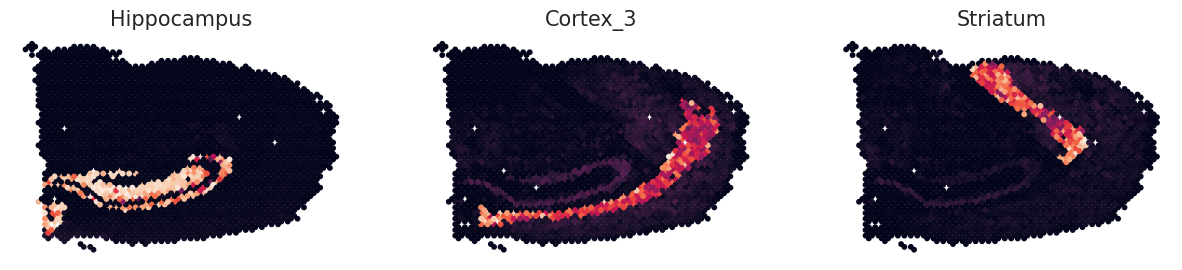

return a figure object


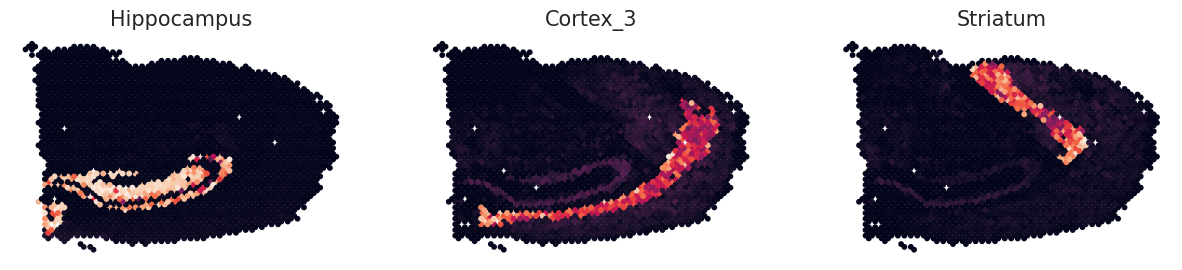

<Figure size 432x288 with 0 Axes>

In [22]:
# ToDo
ct_test = ['Hippocampus','Cortex_3', 'Striatum']
dataset_tissue = sc.AnnData(tissue.ctgw, dtype=float)
dataset_tissue.obsm['spatial'] = locations
novosparc.pl.embedding(dataset_tissue, ct_test)

## ct specific
just use the normal novosparc function and give cell types instead of genes

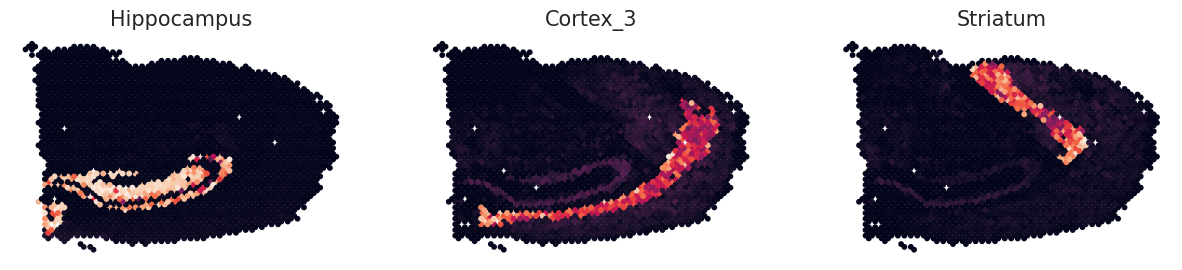

return a figure object


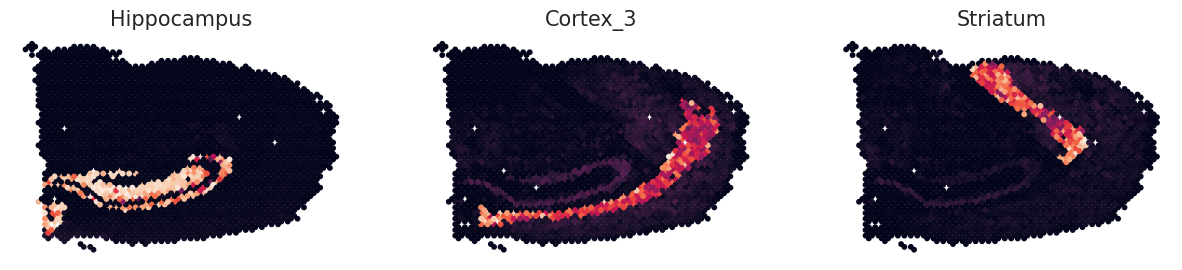

<Figure size 432x288 with 0 Axes>

In [23]:
novosparc.pl.embedding(dataset_tissue, ct_test)

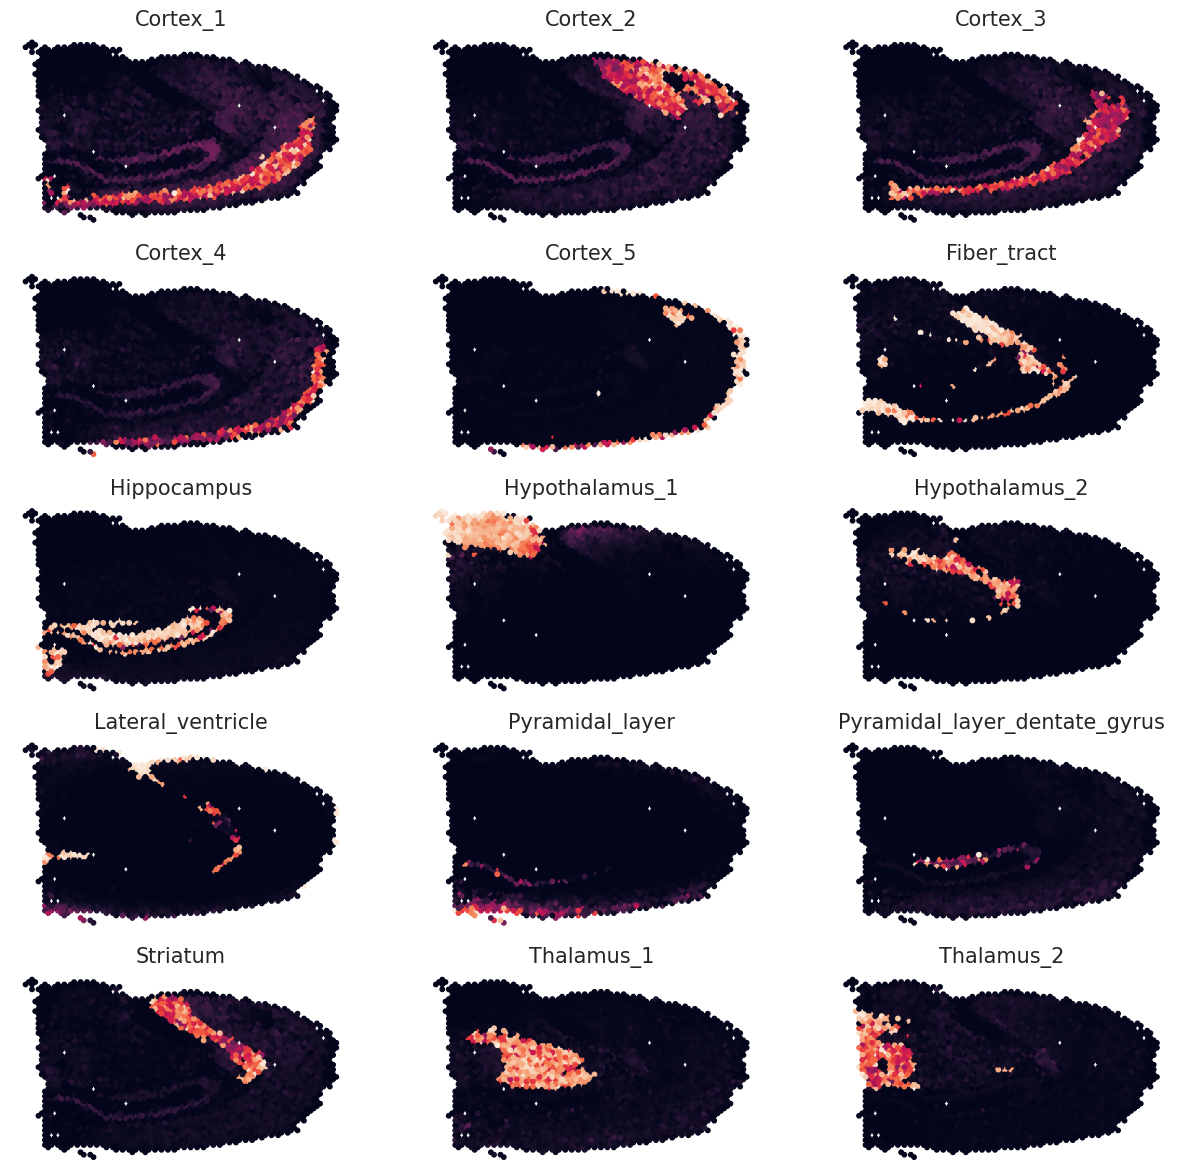

return a figure object


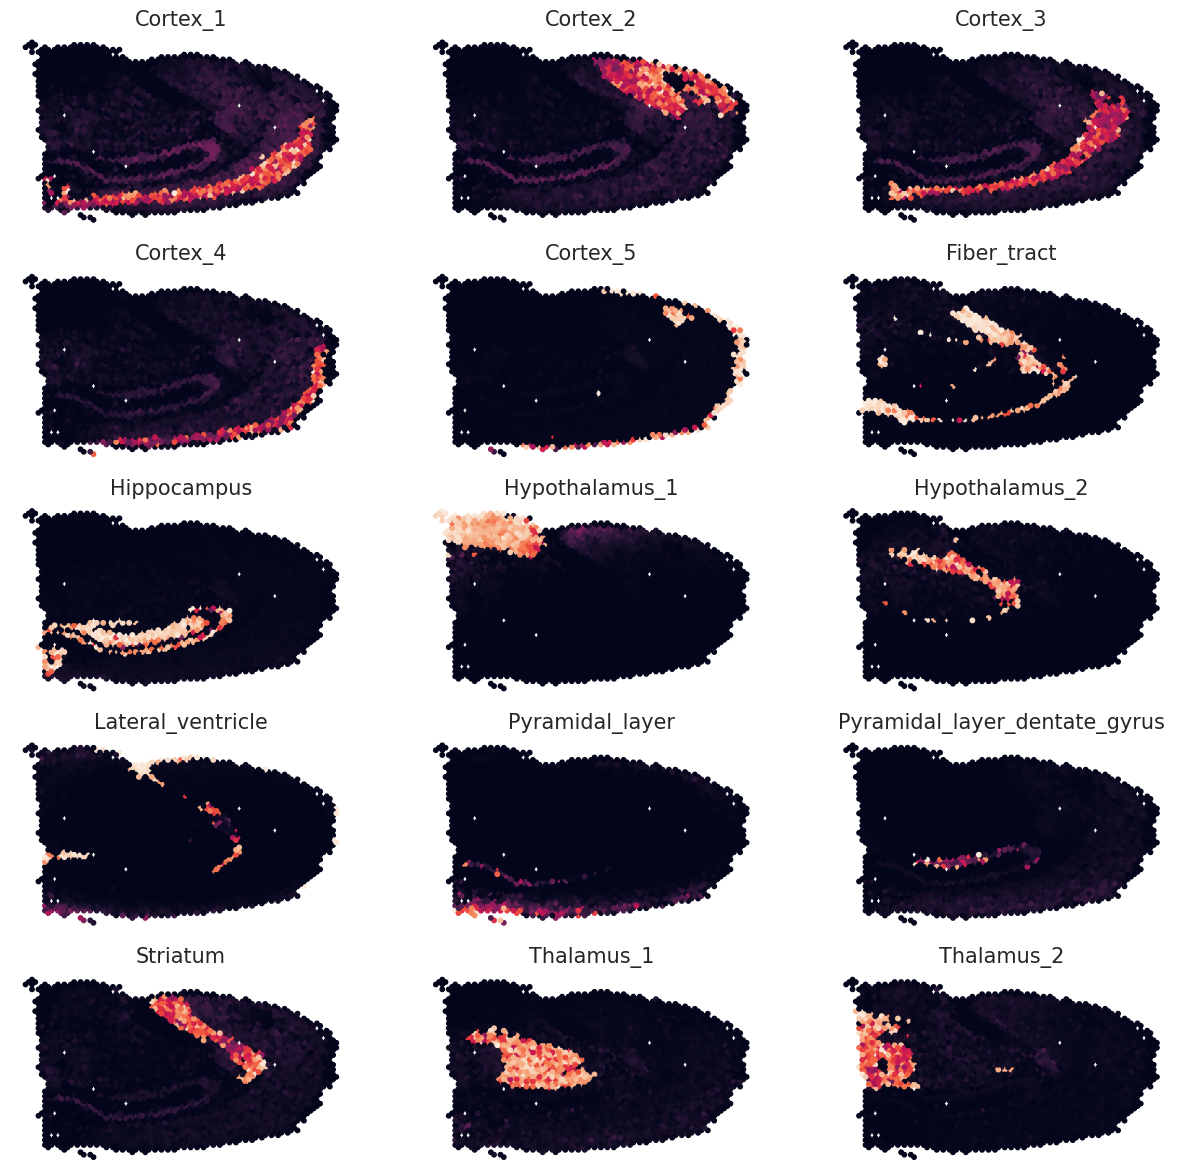

<Figure size 432x288 with 0 Axes>

In [24]:
novosparc.pl.embedding(dataset_tissue, ct_unique)

# Convert mpl to plotly

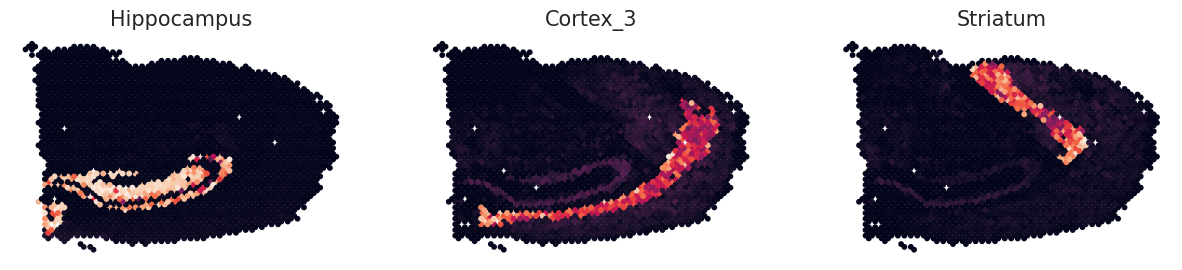

return a figure object


/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/plotly/matplotlylib/mplexporter/exporter.py:289: MatplotlibDeprecationWarning:


The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.



<Figure size 432x288 with 0 Axes>

In [54]:
import plotly
import plotly.tools as tls
plot = novosparc.pl.embedding(dataset_tissue, ct_test)
plotly_fig_1 = tls.mpl_to_plotly(plot)
# plotly.offline.plot(plotly_fig_1, filename="mpl_to_plotly.html")

In [57]:
help(tls.mpl_to_plotly)

Help on function mpl_to_plotly in module plotly.tools:

mpl_to_plotly(fig, resize=False, strip_style=False, verbose=False)
    Convert a matplotlib figure to plotly dictionary and send.
    
    All available information about matplotlib visualizations are stored
    within a matplotlib.figure.Figure object. You can create a plot in python
    using matplotlib, store the figure object, and then pass this object to
    the fig_to_plotly function. In the background, mplexporter is used to
    crawl through the mpl figure object for appropriate information. This
    information is then systematically sent to the PlotlyRenderer which
    creates the JSON structure used to make plotly visualizations. Finally,
    these dictionaries are sent to plotly and your browser should open up a
    new tab for viewing! Optionally, if you're working in IPython, you can
    set notebook=True and the PlotlyRenderer will call plotly.iplot instead
    of plotly.plot to have the graph appear directly in the

# Plot all annotations in one plot
## filter the annotation
with the highest probability per location (maybe the prob value too)

In [26]:
# loop over tissue.ctgw rowwise

# find max value in the row
out_array = np.amax(np.array(tissue.ctgw), axis=1)
# find the values column name - get the index
out_array = np.vstack((out_array, np.argmax(np.array(tissue.ctgw), axis=1)))

# transform to df to enable multiple data types
out_df = pd.DataFrame(out_array.T)
print(out_df.shape)

(2688, 2)


In [40]:

%%time
# write value and column name into the new df
# can I add a new column like this? - yes, but it takes already quite some time
out_df[2] = out_df[1].apply(lambda x: tissue.ctgw.columns[x])
out_df.columns = ["mapping_prop_ct", "mapped_ct_idx", "mapped_ct"]

<timed exec>:3: FutureWarning:

Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.



CPU times: user 1min 39s, sys: 470 ms, total: 1min 40s
Wall time: 1min 40s


In [41]:
# add annotation to the dataset anndata
# why does adding to obs only creates NA ?
dataset_tissue.obsm["mapped_ct"] = out_df["mapped_ct"].to_numpy().reshape(-1,1)
dataset_tissue.obsm["mapping_prop_ct"] = out_df["mapping_prop_ct"].to_numpy().reshape(-1,1)
dataset_tissue.obsm["mapped_ct_idx"] = out_df["mapped_ct_idx"].to_numpy().reshape(-1,1)


## different ideas for filling a dataframe through a loop
Collections of ways to do it. Would have to test which of them is the fastest and most memory efficant one. I think it makes sense to do this already since those df tend to be quite big.

1. in the loop create a list of list and only later transform that list into a df
```
import pandas as pd
list_of_lists = []
list_of_lists.append([1,2,3])
list_of_lists.append([4,5,6])

pd.DataFrame(list_of_lists, columns=['A', 'B', 'C'])
#    A  B  C
# 0  1  2  3
# 1  4  5  6
```
2. use a simple loop to write into a previously initialized df
```
df = pd.DataFrame(columns=('col1', 'col2', 'col3'))
for i in range(5):
   df.loc[i] = ['<some value for first>','<some value for second>','<some value for third>']`
```
3. create a dict in the loop and concat that into a df
```
df = pd.DataFrame(columns=["firstname", "lastname"])

entry = pd.DataFrame.from_dict({
     "firstname": ["John"],
     "lastname":  ["Johny"]
})

df = pd.concat([df, entry], ignore_index=True)
```
4. do a row by row thing using a series
```
df = pd.DataFrame(columns=['a','b','c','d'], index=['x','y','z'])

df.loc['y'] = pd.Series({'a':1, 'b':5, 'c':2, 'd':3})
```
Article about speed comparisons of pandas functions
--> [Architecture & Performance](https://www.architecture-performance.fr/ap_blog/applying-a-row-wise-function-to-a-pandas-dataframe/)

## plot function

In [29]:
xy = dataset_tissue.obsm['spatial']
x = xy[:, 1]
y = xy[:, 0] if xy.shape[1] > 1 else np.ones_like(x)

In [30]:
# transform to df to enable multiple data types
out_df = pd.DataFrame(out_array.T)
print(out_df.shape)

(2688, 2)


In [31]:
# values = dataset_tissue.obsm["mapped_ct_idx"]

In [32]:
# group_codes = {k:idx for idx, k in enumerate(out_df.mapped_ct.unique())}
# group_codes

In [33]:
# size_x = 6
# size_y = 4.5
# fig, axs = plt.subplots(1, 1, figsize=(size_x, size_y), dpi=100)
# axs = axs.flatten() if type(axs) == np.ndarray else [axs]
# for ax in axs:
#     ax.axis('off')
# # ToDo: How do I rotate this so it's correct ?
# scatter = axs[0].scatter(x, y, c=np.array(values), s=10)
# axs[0].set_title("coloring per cell type", size=10)
#
# # this works but I don't know how to get the labels in
# # legend_color = axs[0].legend(*scatter.legend_elements(num=14), title="Cell types")
# # axs[0].add_artist(legend_color)
#
# handles = scatter.legend_elements()[0]
# axs[0].legend(title="Cell types", handles = handles, labels=group_codes.keys())
# plt.show()
# plt.tight_layout()

## Open ToDos

* change the color map
* plot all the cell types to the legend
* I don't think that the numbers are matching the correct number yet
* put the legend next to the figure
* ...

In [34]:
xy = dataset_tissue.obsm['spatial']

In [35]:
x = xy[:, 1]
y = xy[:, 0] if xy.shape[1] > 1 else np.ones_like(x)

In [36]:
import plotly.express as px

In [51]:
values = dataset_tissue.obsm["mapped_ct"]
plot_df = pd.DataFrame(values, columns=["cell types"])

In [52]:
plotly_fig2 = px.scatter(plot_df, x=x, y=y, color="cell types",
                 width=1000, height=800)
plotly_fig2.update_xaxes(showgrid=False, zeroline=False)
plotly_fig2.update_yaxes(showgrid=False, zeroline=False)
plotly_fig2.update_layout(plot_bgcolor="black")
plotly_fig2.show()

# Experiments with plotting
## color + opacity in one plo

## labels as discrete colors with strings as label

In [42]:
# Opacity values\n",
ct_labels = dataset_tissue.obsm["mapped_ct"]
ct_idx = out_df["mapped_ct_idx"]
plot_df = pd.DataFrame({"cell types" : dataset_tissue.obsm["mapped_ct"].tolist(),
                     "ct_idx": dataset_tissue.obsm["mapped_ct_idx"].tolist()
                         })

In [46]:
xy = dataset_tissue.obsm['spatial']
df = pd.DataFrame({'x_lv': xy[:, 1],
                   'y_lv': xy[:, 0] if xy.shape[1] > 1 else np.ones_like(x),
                   'color': ct_idx,
                   'alpha': out_df["mapping_prop_ct"]
                   })

In [43]:
import plotly.express as px
import plotly.graph_objects as go

In [47]:

def flatten(l):
     return [item for sublist in l for item in sublist]
ct_str = flatten(plot_df["cell types"])
#ct_idx = plot_df["ct_idx"]
ct_idx = out_df["mapped_ct_idx"]
print(ct_str[1567])
print(ct_idx[1567])

lbl_mtchng = {k:str(v) for k,v in zip(tuple(ct_idx), tuple(ct_str))}
#lbl_mtchng = {k:str(v) for k,v in zip(tuple(ct_idx), tuple(ct_idx))}

# color legend\n",
clrs_dscrt = px.colors.qualitative.Alphabet[:len(df['color'].unique())]
idx_clr = {idx:str(clr) for idx,clr in zip(df['color'].unique(),set(clrs_dscrt))}
print(idx_clr)
print(idx_clr[2])

Cortex_1
0.0
{1.0: '#E2E2E2', 4.0: '#782AB6', 14.0: '#1CBE4F', 8.0: '#3283FE', 3.0: '#85660D', 5.0: '#DEA0FD', 9.0: '#FE00FA', 0.0: '#325A9B', 7.0: '#FEAF16', 12.0: '#1C8356', 6.0: '#C4451C', 13.0: '#565656', 2.0: '#AA0DFE', 11.0: '#F7E1A0', 10.0: '#16FF32'}
#AA0DFE


In [48]:
# plot
plotly_fig3 = go.Figure()
plotly_fig3.update_xaxes(showgrid=False, zeroline=False)
plotly_fig3.update_yaxes(showgrid=False, zeroline=False)
# fig.update_layout(plot_bgcolor="black")
plotly_fig3.layout.height = 800
plotly_fig3.layout.width = 1000

for c in df['color'].unique():
    df_color = df[df['color'] == c]
    # normalize alpha values
    alpha_raw = df_color['alpha'].to_numpy().reshape(-1,1)
    alpha_norm = (alpha_raw - alpha_raw.min()) / (alpha_raw.max() - alpha_raw.min())
    # plot label color
    plotly_fig3.add_trace(
     go.Scatter(
         x=df_color['x_lv'],
         y=df_color['y_lv'],
         name=lbl_mtchng[c],
         mode="markers",
         # text = out_df[\ mapped_ct\ ], # todo this could be an array of joint string with cell type + probability,
         showlegend=True,
         marker=go.scatter.Marker(
             color=idx_clr[c],
             size=11,
             opacity=alpha_norm ) # I think this has to be another column in that dataframe then
         ))
    plotly_fig3.update_layout(legend=dict(
             bordercolor = idx_clr[c]))

plotly_fig3.show()

## ToDos opactiy plot:
* get a legend/scale for the opactiy values
* think about normalizing the opacity value differently? So that the lowest value can't be 0?

# Save Plotly HTML

In [56]:
with open('plotly_graphs.html', 'a') as f:
    f.write(plotly_fig_1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(plotly_fig2.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(plotly_fig3.to_html(full_html=False, include_plotlyjs='cdn'))